## Advanced Lane Finding

### Udacity Self Driving Car Engineer Nanodegree - Project 4

The goal of this project is to develop a pipeline to process a video stream from a forward-facing camera mounted on the front of a car, and output an annotated video which identifies:

1. The positions of the lane lines
2. The location of the vehicle relative to the center of the lane
3. The radius of curvature of the road
4. The pipeline created for this project processes images in the following steps:

Steps:

* Step 1: Apply distortion correction using a calculated camera calibration matrix and distortion coefficients.
* Step 2: Apply a perspective transformation to warp the image to a birds eye view perspective of the lane lines.
* Step 3: Use color transforms, gradients, etc., to create a thresholded binary image.
* Step 4: Identify the lane line pixels and fit polynomials to the lane boundaries.
* Step 5: Determine curvature of the lane and vehicle position with respect to center.
* Step 6: Warp the detected lane boundaries back onto the original image.
* Step 7: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Imports

In [1]:
from IPython.display import Image
import os
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
from moviepy.editor import VideoFileClip
from utils import show_images

## Autoreload

In [2]:
%load_ext autoreload
%autoreload 2

## Configuration

In [3]:
## Include the plots into the saved jupyter notebook (good for displaying on github, etc)
%matplotlib inline

## Step 1: Distortion Correction

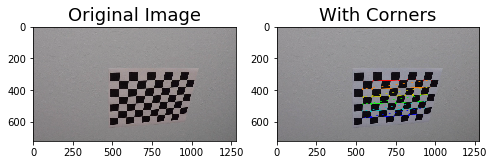

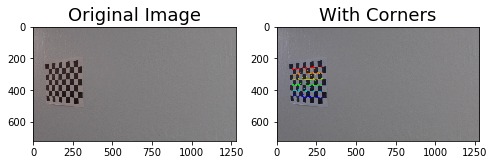

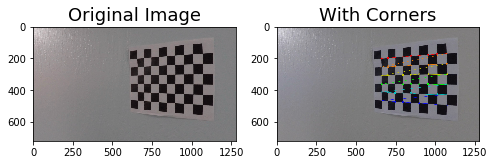

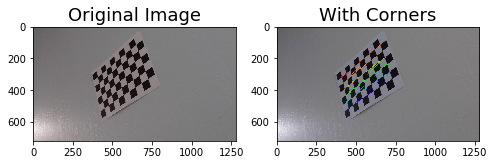

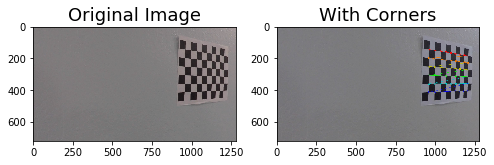

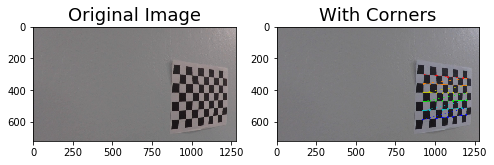

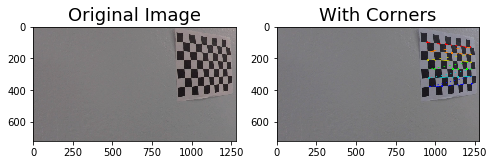

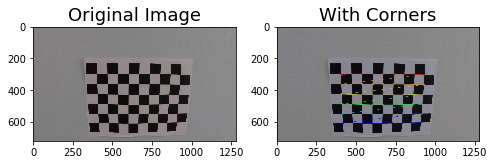

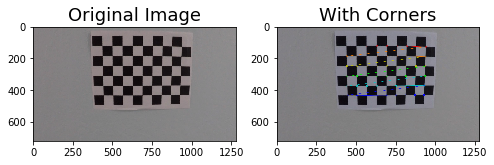

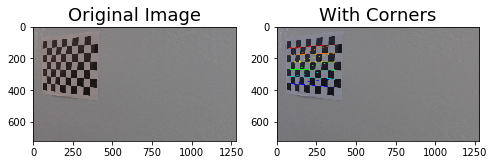

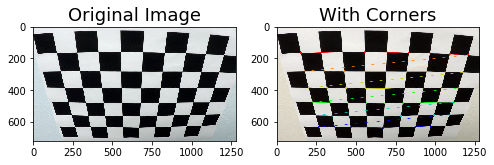

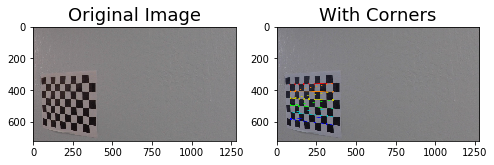

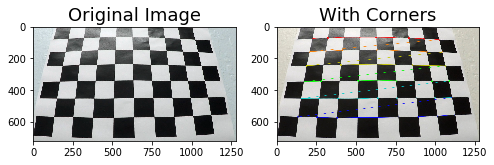

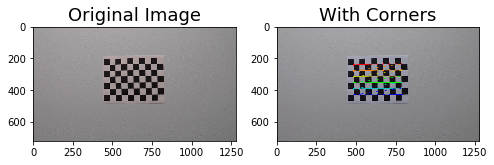

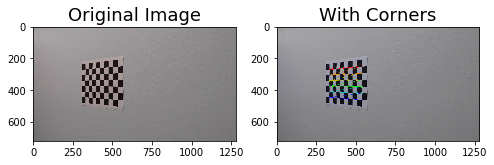

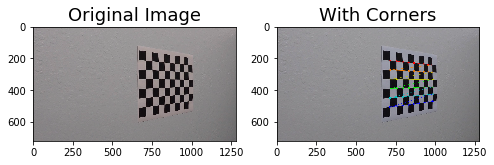

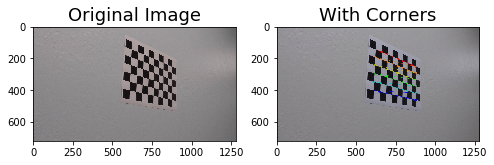

In [4]:
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

nx = 9  # number of corners in x direction
ny = 6  # number of corners in y direction

# Object points
objp = np.zeros((nx * ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx,0:ny].transpose().reshape(-1,2)

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=18)

Define an `undistort` function that uses the above distortion correction parameters to calibrate the camera and then undistort the image.

In [5]:
def undistort(img, show_plot=False):
    
    # Note: this is inefficient to recalibrate each time, and in 
    # a real system this would only happen once and the result would
    # saved
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints,
        imgpoints,
        gray.shape[::-1],
        None,
        None
    )
    
    undistorted = cv2.undistort(
        img,
        mtx,
        dist,
        None,
        mtx
    )
    
    if show_plot:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=20)
    
    return undistorted
    

## Step 2 - Perspective transform

Choose the source region and destination region which the source region will be transformed into (nearly entire image)

In [6]:
src_pts = np.array(
    [[490, 482], # top left
    [810, 482],  # top right
    [1250, 720], # bottom right
    [40, 720]],   # bottom left
    dtype = "float32"
)
dest_pts = np.array(
    [[0, 0],
    [1280, 0],
    [1250, 720],
    [40, 720]],
    dtype = "float32"
)

Define the function that will perform the perspective transform using the regions defined above

In [7]:
def perspective_transform(img, show_plot=False):
        
    img_size = (img.shape[1], img.shape[0])
    
    # Perform perspective transform
    M = cv2.getPerspectiveTransform(src_pts, dest_pts)
    M_inverse = cv2.getPerspectiveTransform(dest_pts, src_pts)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    if show_plot:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Warped Image', fontsize=20)
    
    return warped, M, M_inverse

## Step 3: Apply color thresholds to create a binary image

In [8]:
def binary_threshold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    thresh = (90, 255)
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    return binary 

## Sliding window helper functions

In [9]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [48]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]   # Blue: since it's BGR, first column represents blue  
    out_img[righty, rightx] = [0, 0, 255] # Red
    
    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    left_points = (left_fitx, ploty)
    right_points = (right_fitx, ploty)

    return left_points, right_points, out_img


## Sliding window to discover lane lines

In [11]:
# from 3rd_Party_solns/miguelangel/advanced_lane_finding.ipynb combined with JustinHeaton's version
def draw_lane(img, warped_img, left_points, right_points, Minv):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
  
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped_img.shape[1], warped_img.shape[0]))

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

In [54]:
def draw_lane_no_unwarp(img, warped_img, left_points, right_points, Minv):
    
    """
    Like draw_lane except:
    
    - Does not unwarp the lanes back to the original image
    - Does not superimpose
    """
    
    # Create an image to draw the lines on
    #result_img = np.zeros_like(unwarped_img).astype(np.uint8)
    #color_result_img = np.dstack((result_img, result_img, result_img))
    color_result_img = np.zeros_like(img).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_result_img, np.int_([pts]), (0,255, 0))
    
    return cv2.addWeighted(warped_img, 1, color_result_img, 0.3, 0)
    

## Image Pipeline Result

In [37]:
class ImagePipelineResult:
    def __init__(self):
        self.input_img = None
        self.input_img_filename = None
        self.warped_img = None
        self.M = None
        self.M_inverse = None
        self.undistorted = None
        self.binary_warped_img = None 
        self.left_points = None
        self.right_points = None
        self.raw_lane_lines_img = None
        self.superimposed_lane_lines_img = None
        self.superimposed_unwarped_lane_lines_img = None
    

## Image Pipeline

In [53]:
def image_pipeline(img=None, input_image_name=""):
    
    # Create pipeline result and add input image name
    final_result = ImagePipelineResult()
    final_result.input_img_filename = input_image_name

    # Load image and attach to final result
    if img is None:
        img = cv2.imread(input_image_name)
        final_result.input_img = img
        
    # Undistort
    undistorted = undistort(
        img, 
        show_plot=False
    )
    final_result.undistorted = undistorted
    
    # Get the top-down warped view 
    warped, M, M_inverse = perspective_transform(
        undistorted, 
        show_plot=False
    )
    final_result.warped = warped
    final_result.M = M
    final_result.M_inverse = M_inverse
    
    # Take binary threshold of warped
    binary_warped_img = binary_threshold(warped)
    final_result.binary_warped_img = binary_warped_img
    
    # Calculate lane lines
    left_points, right_points, raw_lane_lines_img = fit_polynomial(binary_warped_img)
    final_result.left_points = left_points
    final_result.right_points = right_points
    final_result.raw_lane_lines_img = raw_lane_lines_img
    
    # Warp lane lines back onto image
    superimposed_lane_lines_img = draw_lane(
        undistorted, 
        binary_warped_img, 
        left_points, 
        right_points, 
        M_inverse
    )
    final_result.superimposed_lane_lines_img = superimposed_lane_lines_img
    
    superimposed_unwarped_lane_lines_img = draw_lane_no_unwarp(
        undistorted, 
        warped, 
        left_points, 
        right_points, 
        M_inverse
    )
    final_result.superimposed_unwarped_lane_lines_img = superimposed_unwarped_lane_lines_img
    
    
    return final_result 
    

## Process single image

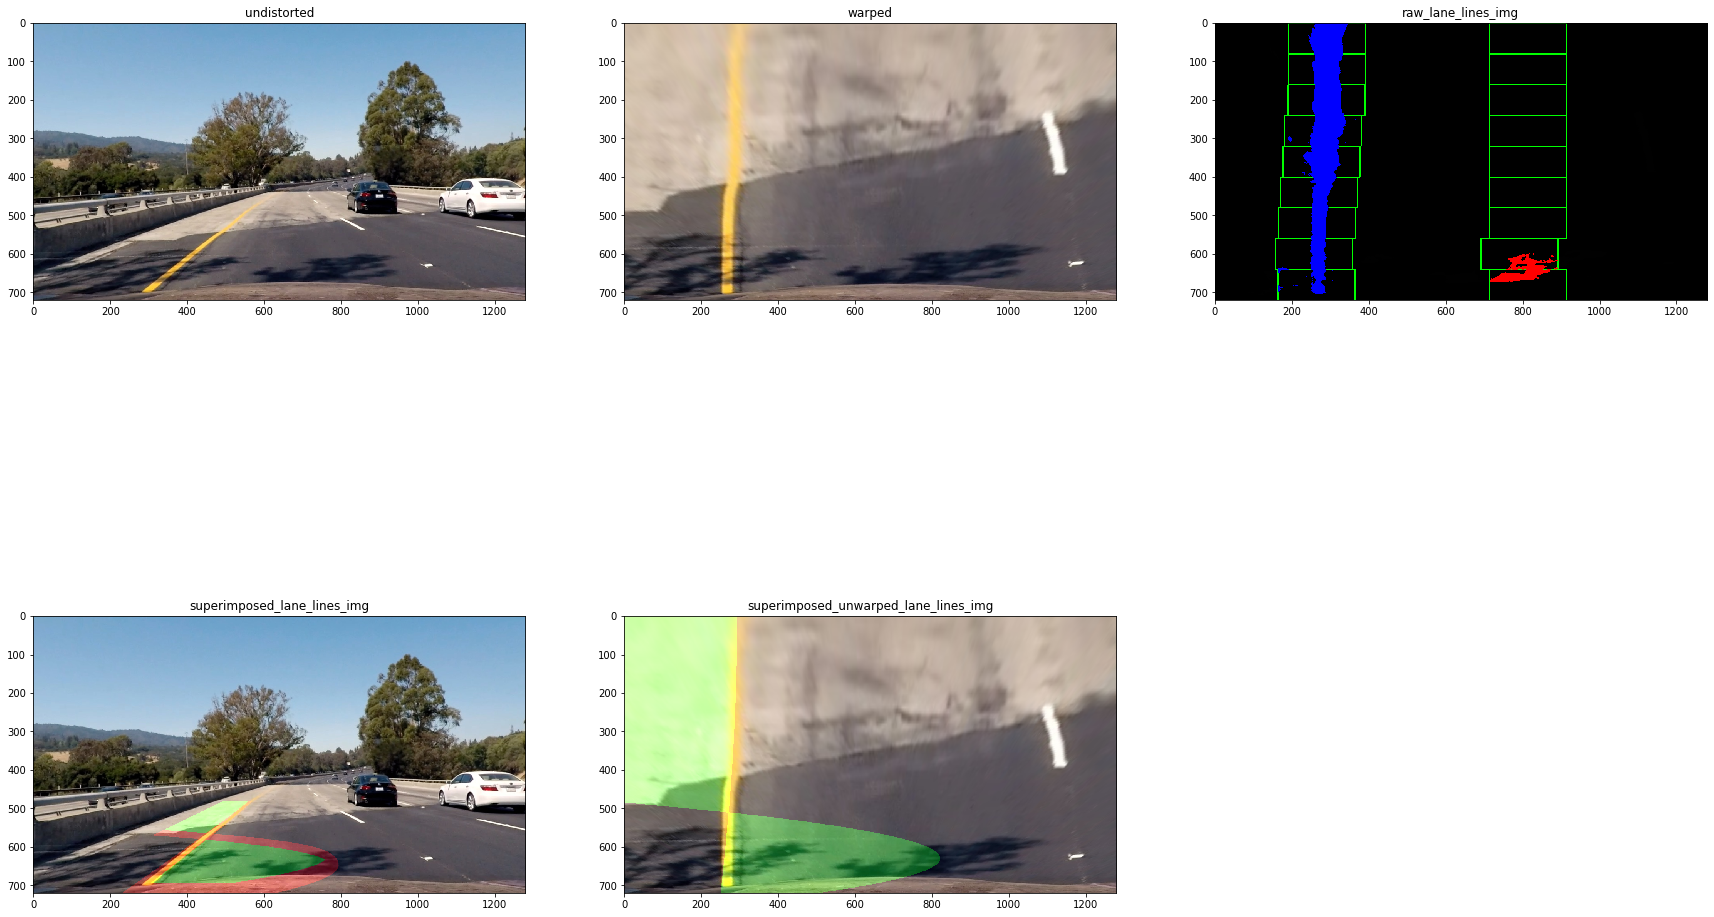

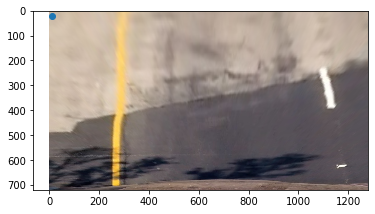

In [62]:
image_name = "test_images/test4.jpg"
final_result = image_pipeline(img=None, input_image_name=image_name)

show_images([
    final_result.undistorted,
    final_result.warped,
    final_result.raw_lane_lines_img,
    final_result.superimposed_lane_lines_img,
    final_result.superimposed_unwarped_lane_lines_img,
    ],
    titles=[
        "undistorted",
        "warped",
        "raw_lane_lines_img",
        "superimposed_lane_lines_img",
        "superimposed_unwarped_lane_lines_img"
    ],
    cv2ConvertTarget=cv2.COLOR_BGR2RGB,
    cols=2,
    scale_factor=1.0,
)

cv2.imwrite("intermediate_images/warped.jpg", final_result.warped)

implot = plt.imshow(cv2.cvtColor(final_result.warped, cv2.COLOR_BGR2RGB))
plt.scatter([10], [20])


In [ ]:
plt.imshow(cv2.cvtColor(final_result.raw_lane_lines_img, cv2.COLOR_BGR2RGB))

In [ ]:
plt.imshow(final_result.binary_warped_img, cmap='gray')


In [ ]:
plt.imshow(cv2.cvtColor(final_result.superimposed_lane_lines_img, cv2.COLOR_BGR2RGB))

## Process all images

In [ ]:
image_names = glob.glob('test_images/test*.jpg')
final_results = []
for image_name in image_names:
    final_result = image_pipeline(img=None, input_image_name=image_name)
    final_results.append(final_result)

In [ ]:
print(final_results[2].input_img_filename)

In [ ]:
plt.imshow(cv2.cvtColor(final_results[2].superimposed_lane_lines_img, cv2.COLOR_BGR2RGB))

## Process video

In [ ]:
class ProcessVideoImage:
    
    def __init__(self):
        pass 

    def __call__(self, img):
        try:
            final_result = image_pipeline(img=img, input_image_name=None)
        except:
            e = sys.exc_info()[0]
            print("Warning: exception processing image.  Exception: {}".format(e))
            return img
        return final_result.superimposed_lane_lines_img

In [ ]:
input_video = './project_video.mp4'
output_video = './project_video_solution.mp4'

## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,5)
clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ProcessVideoImage()

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)